# ISOMAP 
- ISOMAP은 pca와 mds의 주요 특징을 합친 방법으로 비선형 차원 축소 방법론에 해당합니다.
- mds의 경우 포인트간의 pair distance가 저 차원에서도 유지 되도록 하는 것이 목적입니다.
- ISOMAP도 마찬가지 이며 MDS와의 차이점으로는 점간의 거리를 유클리디안 거리를 사용하는 것이 아닌 모든 점 사이의 측지선 거리를 유지하며 더 낮은 차원에서의 매핑을 하는 것을 목적으로 합니다.
- 정리하면 ISOMAP은 원 공간에서 nearest neighbors graph를 만든 뒤 이 그래프에서의 최단 경로로 점들 간의 거리를 정의 합니다. 그리고 이 거리 정보를 최대한 보존하는 저 차원 공간으로 매핑을 합니다.

## 과정

- step 1과 2를 통해 manifold 상에서 두 점 사이의 실제 도달 거리를 찾는 것이 목적
- 그 거리를 이용해 MDS 진행

### 1. 인접한 이웃 그래프 구축 - Distance 계산

- 매니폴드 상에서 점들이 서로 가까이 위치하는지를 측정
- 측정하는 방식엔 두가지가 있음
    1. $\epsilon-Isomap$ : 특정 기준값 보다 가까운 경우 모두 연결 
    2. $k-Isomap$ : knn 방식으로 k개의 가장 가까운 점들 연결 

### 2. 두 점 간의 최단 경로 그래프 계산 - Distance Matrix 생성

- 두 점 i와 j에 대해 두 점이 서로 연결되어 있다면 $d_G(i,j) = d_x(i,j)$
- 두 점 i와 j에 대해 두 점이 서로 연결되어 있지 않다면 무한으로 초기화
- 노드간의 최단 거리를 찾는 알고리즘을 통해 distance 정보 update
- 이를 이용해 MDS를 수행 가능한 distance matrix 생성

### 3. MDS를 이용해 d차원 임베딩 구축

## 데이터 로드 

In [23]:
from sklearn.datasets import load_digits
import numpy as np 
from tqdm import tqdm 
import pandas as pd 


data = load_digits()
input_x = data.data
input_y = data.target
#계산 용이성을 위해 minmax 진행 
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
input_x = minmax.fit_transform(input_x).astype(np.float16)


## step 1 : 인접한 이웃 그래프 구축 - Distance 계산 

In [37]:
n_neighbours = 20 
i = 0 
point = input_x[i]
neighbours_distance = pd.DataFrame(np.sum((input_x-point)**2,axis=1)).sort_values(by=0,ascending=False)[0].iloc[:n_neighbours]
neighbours_index = neighbours_distance.index

In [82]:
# 빈 Distance Matrix 생성 
Dmatrix = np.zeros(input_x.shape[0]**2).reshape(input_x.shape[0],-1)

#하이퍼 파라미터 설정 
n_neighbours = 20 
for i in tqdm(range(len(input_x))):
    point = input_x[i]
    neighbours_distance = pd.DataFrame(np.sum((input_x-point)**2,axis=1)).sort_values(by=0,ascending=True)[0].iloc[:n_neighbours]
    neighbours_index = neighbours_distance.index    
    Dmatrix[i,neighbours_index] = neighbours_distance.values

100%|██████████| 1797/1797 [00:10<00:00, 176.61it/s]


## Step 2 : shorted Distance Graph 구축 

In [139]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
nbg = kneighbors_graph(
    Dmatrix,
    n_neighbors=n_neighbours,
    metric = 'minkowski',
    p= 2,
    mode="distance"
)
n_conntected_components, labels = connected_components(nbg)
dist_matrix_ = shortest_path(nbg, method='auto', directed=False)
G = dist_matrix_**2
G *= -0.5 


## Step 3 : MDS를 이용해 d차원 임베딩 매핑 후 시각화 

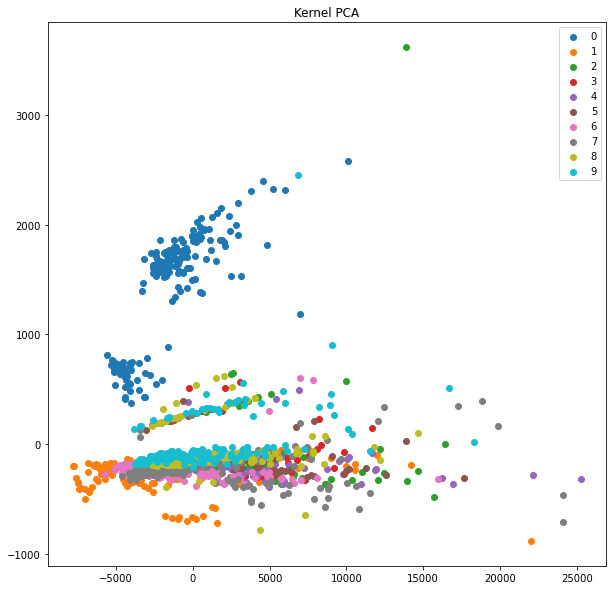

In [149]:
import matplotlib.pyplot as plt 
from sklearn.decomposition import KernelPCA
kpca = KernelPCA()
pca_x = kpca.fit_transform(G)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(pca_x[input_y==i][:,0],
                pca_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("Kernel PCA")
plt.show()                    

c:\Users\dags8\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


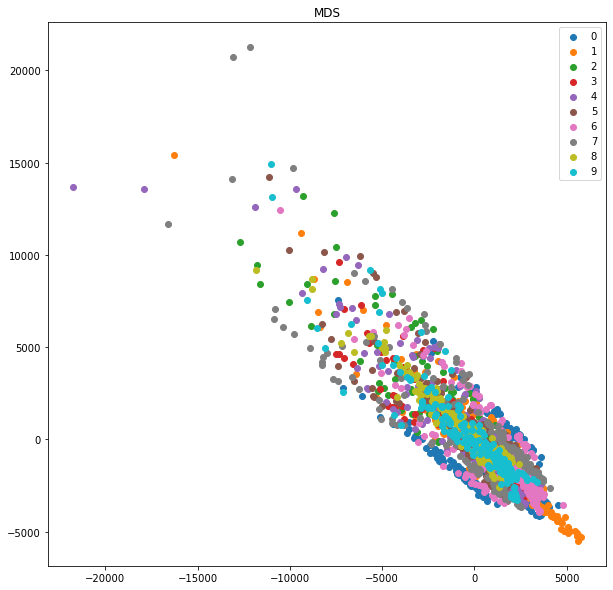

In [150]:
import matplotlib.pyplot as plt 
from sklearn.manifold import MDS 

mds = MDS()
mds_x = mds.fit_transform(G)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("MDS")    
plt.show()                    

c:\Users\dags8\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\dags8\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


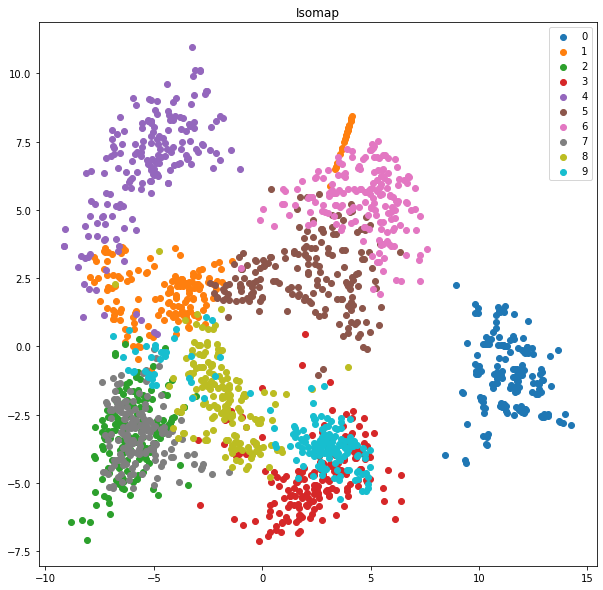

In [153]:
from sklearn.manifold import Isomap
isomap = Isomap()
mds_x = isomap.fit_transform(input_x)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("Isomap")    
plt.show()            

# LLE 
- https://blog.paperspace.com/dimension-reduction-with-lle/